In [49]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<Axes: >

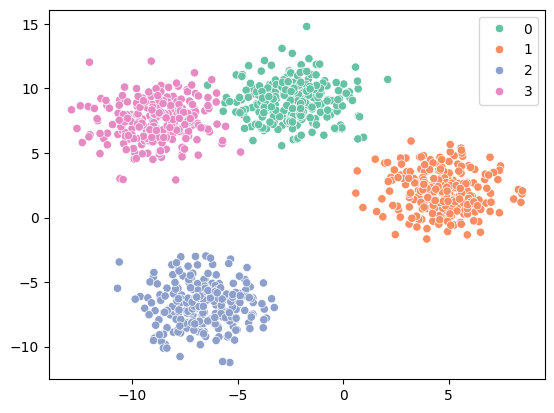

In [51]:
## Buat dataset
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=1000,n_features=2,centers=4,cluster_std=1.5,random_state=42)

sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette="Set2")

In [52]:
X = torch.from_numpy(X).type(dtype=torch.float)
y = torch.from_numpy(y).type(dtype=torch.LongTensor)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
           X, y, test_size=0.2, random_state=42)

In [54]:
X_train.shape,y_train.shape,torch.unique(y_train)

(torch.Size([800, 2]), torch.Size([800]), tensor([0, 1, 2, 3]))

In [55]:
from torch import nn

class MultiClassModelV0(nn.Module):
    def __init__(self,input_features,output_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_features, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_features),
        )

    def forward(self,x):
        return self.layers(x)

In [56]:
def accuracy_score(y_true,y_pred):
    total_true = (y_true == y_pred).sum().item()
    acc = 100 * total_true / len(y_true)
    return acc

In [57]:
multi_class_model_v0  = MultiClassModelV0(input_features=2,output_features=4)

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=multi_class_model_v0.parameters(),lr=0.1)

In [59]:
multi_class_model_v0.to(device)

MultiClassModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [60]:
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
epochs_value = []
train_error: list = []
test_error: list = []

for epoch in range(epochs + 1):
    multi_class_model_v0.train()

    y_train_logits = multi_class_model_v0(X_train)
    y_train_pred = torch.softmax(y_train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(y_train_logits, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        epochs_value.append(epoch)
        train_error.append(train_loss)

        multi_class_model_v0.eval()
        with torch.inference_mode():

            y_test_logits = multi_class_model_v0(X_test)
            y_test_pred = torch.softmax(y_test_logits,dim=1).argmax(dim=1)
            
            test_loss = loss_fn(y_test_logits,y_test)
            test_error.append(test_loss)

        print(
            f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train acc: {accuracy_score(y_train,y_train_pred)} | Test loss: {test_loss:.4f} | Test acc: {accuracy_score(y_test,y_test_pred)}"
        )

Epoch: 0 | Train Loss: 1.4125 | Train acc: 9.5 | Test loss: 1.3891 | Test acc: 20.5
Epoch: 10 | Train Loss: 1.1113 | Train acc: 26.125 | Test loss: 1.1599 | Test acc: 20.5
Epoch: 20 | Train Loss: 0.9919 | Train acc: 58.875 | Test loss: 1.0519 | Test acc: 61.5
Epoch: 30 | Train Loss: 0.8787 | Train acc: 68.5 | Test loss: 0.9346 | Test acc: 66.5
Epoch: 40 | Train Loss: 0.7139 | Train acc: 96.375 | Test loss: 0.7542 | Test acc: 97.0
Epoch: 50 | Train Loss: 0.4920 | Train acc: 94.25 | Test loss: 0.5007 | Test acc: 93.5
Epoch: 60 | Train Loss: 0.3527 | Train acc: 97.0 | Test loss: 0.3583 | Test acc: 96.5
Epoch: 70 | Train Loss: 0.2884 | Train acc: 98.125 | Test loss: 0.2924 | Test acc: 99.0
Epoch: 80 | Train Loss: 0.2475 | Train acc: 98.75 | Test loss: 0.2496 | Test acc: 99.5
Epoch: 90 | Train Loss: 0.2170 | Train acc: 98.875 | Test loss: 0.2177 | Test acc: 99.5
Epoch: 100 | Train Loss: 0.1930 | Train acc: 99.0 | Test loss: 0.1925 | Test acc: 99.5


In [62]:
import sys
from pathlib import Path

sys.path.append(str(Path("helper_functions.py").resolve().parent.parent))

# Setelah parent path ditambahkan, kamu bisa mengimpor seperti biasa
from helper_functions import plot_decision_boundary

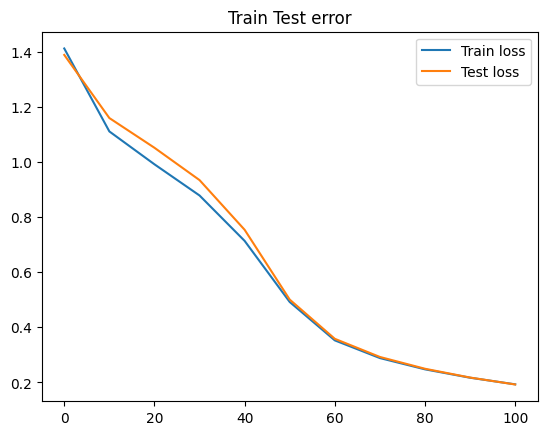

In [63]:
plt.title("Train Test error")
plt.plot(torch.tensor(epochs_value).cpu(),torch.tensor(train_error).cpu(),label="Train loss")
plt.plot(torch.tensor(epochs_value).cpu(), torch.tensor(test_error).cpu(),label="Test loss")

plt.legend()

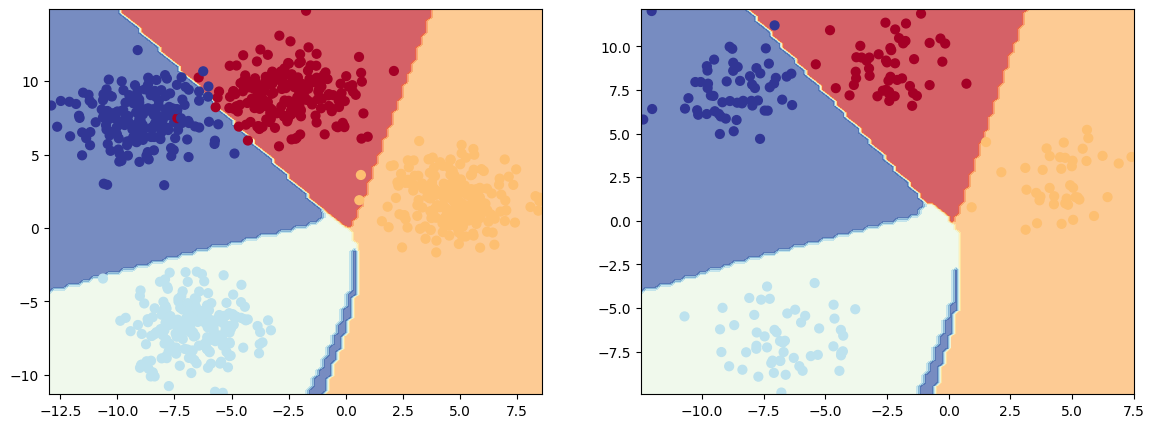

In [64]:
fig,axes = plt.subplots(1,2,figsize=(14,5))

plt.sca(axes[0])
plot_decision_boundary(multi_class_model_v0,X_train,y_train)

plt.sca(axes[1])
plot_decision_boundary(multi_class_model_v0, X_test, y_test)

In [66]:
import torchmetrics
from torchmetrics.classification import MulticlassF1Score,Accuracy

accuracy = Accuracy( task="multiclass", num_classes=4).to(device)
f1score = MulticlassF1Score(num_classes=4).to(device)

print(f"Final test acc: {accuracy(y_test_pred, y_test):.4f}")
print(f"Final f1 score: {f1score(y_test_pred,y_test):.4f}")

Final test acc: 0.9950
Final f1 score: 0.9953
